In [1]:
!aws s3 sync s3://rowerki ./data

Completed 128.3 KiB/128.3 KiB (171.1 KiB/s) with 1 file(s) remaining
download: s3://rowerki/1652030504.csv to data\1652030504.csv        


In [2]:
import os
import requests 
import pandas as pd 
import matplotlib.pyplot as plt 

In [3]:
json = requests.get("https://nextbike.net/maps/nextbike-official.json?city=372,210,475").json()
data = []
for city in json["countries"][0]['cities']:
    for place in city['places']:
        data.append({col: place[col] for col in ['uid', 'lat', 'lng', 'name','bike_racks']})
stations = pd.DataFrame(data)
stations.sort_values("bike_racks")

,uid,lat,lng,name,bike_racks
329,2681635,52.234390,20.999159,Spektrum Tower,11
342,18751910,52.183037,20.991542,Signum Work Station,12
348,55316960,52.196220,20.938810,Bolero,15
76,2585400,52.231450,20.988690,Prosta - Wronia,15
267,2586001,52.247314,21.042731,Metro Stadion Narodowy,15
...,...,...,...,...,...
201,2585885,52.157289,21.044008,Rosoła - Ciszewskiego - SGGW,30
207,2585901,52.142720,21.038362,Pileckiego - Alternatywy,30
60,2585369,52.244947,21.001294,Andersa - Długa,30
210,2585905,52.140391,21.056819,Metro Natolin,30


In [4]:
data_path = '.\data'
bikes = pd.concat([pd.read_csv(os.path.join(data_path, p)) for p in os.listdir(data_path)]).reset_index()
bikes['date'] = pd.to_datetime(bikes['date'])
bikes['day'] = bikes['date'].dt.floor('d')
bikes

,index,date,station_id,bike_number,bike_type,state,day
0,0,2022-04-24 17:18:00,2585259,24927,174,ok,2022-04-24
1,1,2022-04-24 17:18:00,2585259,24801,174,ok,2022-04-24
2,2,2022-04-24 17:18:00,2585259,24655,174,ok,2022-04-24
3,3,2022-04-24 17:18:00,2585259,24648,174,ok,2022-04-24
4,4,2022-04-24 17:18:00,2585259,27559,174,ok,2022-04-24
...,...,...,...,...,...,...,...
3007651,3465,2022-05-08 17:21:00,48372123,24891,174,ok,2022-05-08
3007652,3466,2022-05-08 17:21:00,48372123,26843,174,ok,2022-05-08
3007653,3467,2022-05-08 17:21:00,48372123,96565,174,ok,2022-05-08
3007654,3468,2022-05-08 17:21:00,55316960,96033,174,ok,2022-05-08


In [5]:
bikes['prev_station'] = bikes\
.sort_values(by=['date'], kind='stable')\
.groupby(['bike_number'])\
.shift(1)['station_id'].astype('Int64')
bikes['next_station'] = bikes\
.sort_values(by=['date'], kind='stable')\
.groupby(['bike_number'])\
.shift(-1)['station_id'].astype('Int64')
# You can't do next != current because it does not detect loops
bikes['just_returned'] = bikes\
.sort_values(by=['date'], kind='stable')\
.groupby(['bike_number', 'station_id'])\
.shift(1)['date'].isna() | (bikes['prev_station'] != bikes['station_id'])
bikes['just_rented'] = bikes\
.sort_values(by=['date'], kind='stable')\
.groupby(['bike_number', 'station_id'])\
.shift(-1)['date'].isna() | (bikes['next_station'] != bikes['station_id'])
bikes[bikes['bike_number'] == 96033].sort_values(by=['date'], kind='stable')

,index,date,station_id,bike_number,bike_type,state,day,prev_station,next_station,just_returned,just_rented
8782,1198,2022-04-24 15:44:00,2585470,96033,174,ok,2022-04-24,<NA>,2585470,True,False
12608,1201,2022-04-24 15:44:00,2585470,96033,174,ok,2022-04-24,2585470,2585470,False,False
16435,1201,2022-04-24 15:51:00,2585470,96033,174,ok,2022-04-24,2585470,2585470,False,False
20295,1241,2022-04-24 16:21:00,2585470,96033,174,ok,2022-04-24,2585470,2585470,False,False
24302,1335,2022-04-24 16:51:00,2585470,96033,174,ok,2022-04-24,2585470,2585470,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2994544,3071,2022-05-08 15:21:00,55316960,96033,174,ok,2022-05-08,55316960,55316960,False,False
2997662,3116,2022-05-08 15:51:00,55316960,96033,174,ok,2022-05-08,55316960,55316960,False,False
3000871,3207,2022-05-08 16:21:00,55316960,96033,174,ok,2022-05-08,55316960,55316960,False,False
3004184,3311,2022-05-08 16:51:00,55316960,96033,174,ok,2022-05-08,55316960,55316960,False,False


In [6]:
grouped = bikes\
.groupby(['date', 'station_id'])\
.aggregate({'bike_number' : len, 'just_returned' : sum,'just_rented' : sum})\
.reset_index()\
.rename(columns={'bike_number': 'bike_count'})\
.merge(stations,left_on = 'station_id', right_on = 'uid')
grouped['just_rented'] = grouped.sort_values(['date']).groupby('station_id').shift(1)['just_rented']
grouped

,date,station_id,bike_count,just_returned,just_rented,uid,lat,lng,name,bike_racks
0,2022-04-24 15:44:00,448565,6,3,NaN,448565,52.183992,21.009840,Nestle House,15
1,2022-04-24 15:51:00,448565,4,1,0.0,448565,52.183992,21.009840,Nestle House,15
2,2022-04-24 16:21:00,448565,1,0,3.0,448565,52.183992,21.009840,Nestle House,15
3,2022-04-24 16:51:00,448565,5,4,0.0,448565,52.183992,21.009840,Nestle House,15
4,2022-04-24 17:21:00,448565,7,6,4.0,448565,52.183992,21.009840,Nestle House,15
...,...,...,...,...,...,...,...,...,...,...
230528,2022-05-08 15:21:00,2585788,3,0,2.0,2585788,52.204264,21.014428,Madalińskiego - Kazimierzowska,24
230529,2022-05-08 15:51:00,2585788,7,4,0.0,2585788,52.204264,21.014428,Madalińskiego - Kazimierzowska,24
230530,2022-05-08 16:21:00,2585788,2,0,5.0,2585788,52.204264,21.014428,Madalińskiego - Kazimierzowska,24
230531,2022-05-08 16:51:00,2585788,3,1,0.0,2585788,52.204264,21.014428,Madalińskiego - Kazimierzowska,24


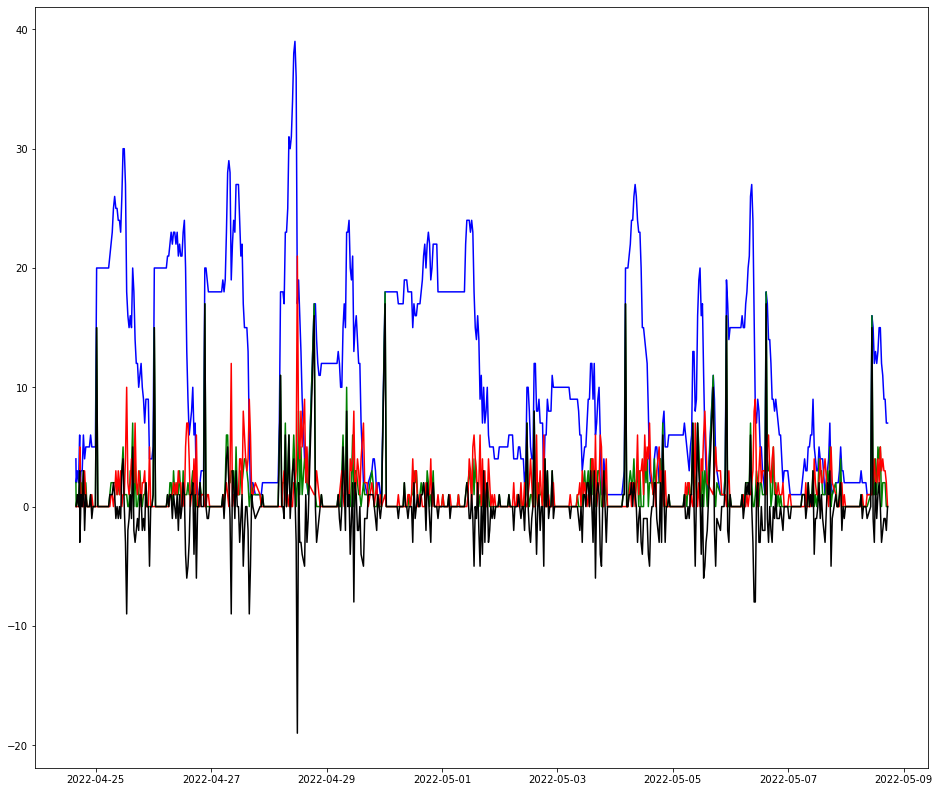

In [7]:
df = grouped[grouped['name'] == "Plac Politechniki"]
plt.figure(figsize=(16,14))
for col, y in [("blue", "bike_count"), ("green", 'just_returned'), ("red", 'just_rented')]:
    plt.plot(df["date"], df[y], c=col)
plt.plot(df["date"], df['just_returned'] - df['just_rented'], c='black')